# Stock Price simulation using Generative Adversarial Network  (GAN)

## Modules 
In this section we will load all the modules that will be needed for the purposes of our project

### Basic Modules

In [408]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import os
import time

### Tensorflow
For this project we will be using Tensorflow's to train our Neural Network


In [409]:
import tensorflow as tf
import tensorflow.keras.layers as layers

In [410]:
data = pd.read_csv("drive/My Drive/AAPL.csv")
data.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2006,6.999730,7.228929,6.987158,7.228929,201808600
1,1/4/2006,7.265678,7.347880,7.204753,7.250205,154900900
2,1/5/2006,7.236664,7.243433,7.132219,7.193145,112355600
3,1/6/2006,7.277282,7.417508,7.209586,7.378825,176114400
4,1/9/2006,7.420411,7.465863,7.324670,7.354649,168760200


## Defining Parameters
In this section we are predefining all the parameters that we would need to use in the project. This is an easy one stop solution to try and fine tune these parameters later on to get the maximum accuracy.

In [411]:
# Defining Parameters 

n1 = 60 # number of days used as input for our model
n2 = 15 # number of days the model will predict

# Generator Parameters

gnl = 3 # number of hidden layers used in the generator neural network
gnl_nodes = [600,600,600] # number of nodes used in each of the hidden layer 

# Discriminator Parameters

dnl = 3 # number of hhidden layers used in the discriminatot neural network
dnl_nodes = [600,600,600] # number of nodes used in each of the hidden layers

# Parameters for Advanced metrics
MAn = 30
ROCn = 30
RSIn = 30
FastKn = 14
SlowKn = 3
SlowDn = 3
Upkn = 15
Lowkn = 15

# training parameters

EPOCHS = 500 # Number of complete passes through the training dataset
Batch_Size = 250 # The number of values used before updating the weights of the networks

## Advanced Metrics
Since we are trying to predict the stock price It's important to add a few more metrics like moving average and Rate of change which are commonly used in finance as inputs to our Neural Network

### Moving Average  

In [412]:

# Moving Average
def MA(a, n=MAn):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    ret[n - 1:] = ret[n - 1:] / n
    ret[:n-1] = 0
    return ret
  


### Rate of change
Formula

$ ROC price = \frac{cur_{price} - prev_{price}}{prev_{price}} $

In [413]:
# ROC rate of change 
def ROC(a, n=ROCn):
    
    re = ((a[n:] - a[:len(a)-n])/a[:len(a)-n])*100
    re = np.concatenate((np.zeros(n),np.array(re)))
    return re
    

### Relative Strength Index
Formula:

$ RSI_{step one} = 100 - \left[ \frac{100}{1 + \frac{Average Gain}{Average Loss}} \right] $

In [414]:
# RSI Relative strength index

def singleRSI(a):
    
    # daily gain or loss
    
    ret = (a[1:] - a[:len(a)-1])/a[:len(a)-1]
    zero = np.zeros(len(a)-1)
    ind = ret > zero
    avg_gain = np.mean(ret[ind])
    avg_loss = np.mean(-ret[np.logical_not(ind)])
    return 100 - (100/(1 + (avg_gain/avg_loss)))

def RSI(a, n=RSIn):

    re = np.zeros(len(a)-n)
    for i in range(len(a)-n):
        re[i] = singleRSI(a[i:n+i])
    
    return np.concatenate((np.zeros(n),re))

### Stochastics 
FastK, SlowK and SlowD are different stochastics which are trying to measure the sensitivity of the stock price.

FastK Formula:

$ FastK = \frac{100 * (CP - L14)}{(H14 - L14} $

CP = Closing Price

L14 = Lowest Price of the previous 14 days

H14 = Highest Price of the previous 14 days

In [415]:
# FastK 
def FastK(a, k=FastKn):
    
    re = np.zeros(len(a)-k)
    for i in range(len(a)-k):
        re[i] = 100*(a[i] - min(a[i:k+i]))/(max(a[i:k+i]) - min(a[i:k+i]))
    
    return np.concatenate((np.full([k], 0),re))

SlowK = Moving Average of 3 prev FastKs

In [416]:
# SlowK
def SlowK(a, k=SlowKn):
    
    return MA(FastK(a),k)
    

SlowD = Moving Average of 3 prev SlowKs

In [417]:
# SlowD
def SlowD(a, k=SlowDn):
    
    return MA(SlowK(a),k)

In [418]:
# Upk's and Lowk's
def Upk(a, n1 = Upkn):
    
    re = np.zeros(len(a)-n1)
    for i in range(len(a)-n1):
        re [i] = max(a[i:n1+i])
    
    return np.concatenate((np.full([n1], 0),re))

def Lowk(a, n1 = Lowkn):
    
    re = np.zeros(len(a)-n1)
    for i in range(len(a)-n1):
        re [i] = min(a[i:n1+i])
    
    return np.concatenate((np.full([n1], 0),re))

### Normalization
We are Pre-processing History Indictors. Basically passing alll our input features through a normalization technique. We are normalizing all indictor between [-1,1] 

In [419]:
# Normalize Function between (-1,1)

def Norm(a):
    
    return (-1 + 2*((a - min(a))/(max(a)-min(a))))

def Norm_df(df):
    
    for i in df.columns:
        
        if i != 'Date':
            df[i] = Norm(np.array(df[i]))
    
    return df

### Putting all features together
In this step we add all the calculated features to our data

In [420]:
# populating calculated values

# MA
data['MA'] = MA(np.array(data['Close']))

# ROC 
data['ROC'] = ROC(np.array(data['Close']))

# RSI
data['RSI'] = RSI(np.array(data['Close']))

# FastK
data['FastK'] = FastK(np.array(data['Close']))

#SlowK
data['SlowK'] = SlowK(np.array(data['Close']))

#SlowD
data['SlowD'] = SlowD(np.array(data['Close']))

#UpK
data['Upk'] = Upk(np.array(data['Close']))

#Lowk
data['Lowk'] = Lowk(np.array(data['Close']))

data = Norm_df(data)


In [421]:
data.head()

,Date,Open,High,Low,Close,Volume,MA,ROC,RSI,FastK,SlowK,SlowD,Upk,Lowk
0,1/3/2006,-0.977509,-0.976298,-0.975635,-0.973660,-0.542341,-1.0,0.028119,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,1/4/2006,-0.974514,-0.974964,-0.973154,-0.973419,-0.655132,-1.0,0.028119,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,1/5/2006,-0.974841,-0.976135,-0.973981,-0.974065,-0.757433,-1.0,0.028119,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,1/6/2006,-0.974384,-0.974184,-0.973099,-0.971964,-0.604123,-1.0,0.028119,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,1/9/2006,-0.972772,-0.973642,-0.971786,-0.972238,-0.621807,-1.0,0.028119,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


## Plotting 
This section contains fews plots of our previously calculated metrics so you can clearly understand the use of these particular metrics

### Closing Price
Looking at the closing price closely we can see that the stock of AAPL has risen significantly since 2006

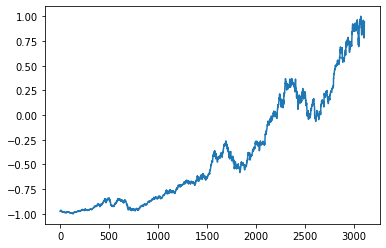

In [422]:
plt.plot(data['Close'])

### Movementum 
The Stock Price Movementum can be calculated using ROC and RSI

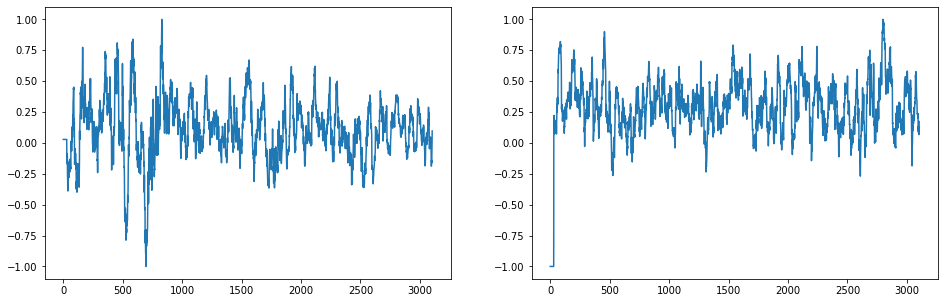

In [423]:
fig, (axs1, axs2) = plt.subplots(1,2, figsize=(16,5))
axs1.plot(data['ROC'])
axs2.plot(data['RSI'])


### Stochastics 
Stochastics are used to measure the sensitivities of the stock price. We are using 3 Stochastics. The slower the stochastic the less sensitive it is to change. So the curve of SlowK is smoother than FastK and similarly the curve of SlowD is smoother than SlowK.  

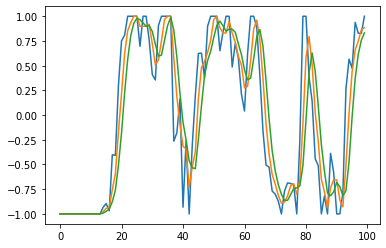

In [424]:
plt.plot(data['FastK'][:100])
plt.plot(data['SlowK'][:100])
plt.plot(data['SlowD'][:100])

## Final step in Data processing 
The final step in data processing is getting the data in the format we need. We are using the past N1 days data as input and next N2 days as output. Our original Data has 13 columns and so the Input data has N1*13 entries and our output data is just N2 values of the stock price.   

In [425]:
ini_drp = max(MAn, ROCn, RSIn, FastKn, SlowKn, SlowDn, Upkn, Lowkn)
data = data[ini_drp:] # we are dropping a few initial values as they will not have a few values
data = data.drop(columns=['Date'])

input_data = []
output_data = []

for i in range(len(data)-n1-n2):
    input_data.append(data[i:i+n1].values.flatten())
    output_data.append(data['Close'][i+n1:i+n1+n2].values.flatten())

input_data = pd.DataFrame(input_data)
output_data = pd.DataFrame(output_data)


## Creating Models 

### Creating the generator model

In [426]:
def make_generator_model():

    model = tf.keras.Sequential()
    model.add(layers.Dense(gnl_nodes[0], use_bias=True, input_shape=(n1*13,), activation = "tanh"))

    for i in range(gnl-1):
        
        model.add(layers.Dense(gnl_nodes[i+1], use_bias=True, activation = "tanh"))
    
    model.add(layers.Dense(n2, activation="tanh"))

    return model
  
    

### Testing our generator

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 600)               468600    
_________________________________________________________________
dense_52 (Dense)             (None, 600)               360600    
_________________________________________________________________
dense_53 (Dense)             (None, 600)               360600    
_________________________________________________________________
dense_54 (Dense)             (None, 15)                9015      
Total params: 1,198,815
Trainable params: 1,198,815
Non-trainable params: 0
_________________________________________________________________
None


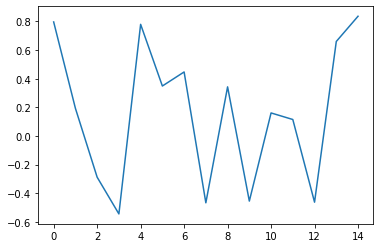

In [427]:
generator = make_generator_model()

generated_values = generator(np.matrix(np.random.randn(780)))

print(generator.summary())
plt.plot(np.transpose(np.matrix(generated_values)))

### Creating the Discriminator model

In [428]:
def make_discriminator_model():

    model = tf.keras.Sequential()
    model.add(layers.Dense(dnl_nodes[0], use_bias=True, input_shape=(n2,), activation = "tanh"))

    for i in range(dnl-1):
        
        model.add(layers.Dense(dnl_nodes[i+1], use_bias=True, activation = "tanh"))
    
    model.add(layers.Dense(1, activation="sigmoid"))

    return model

### Testing our discriminator

In [429]:
discriminator = make_discriminator_model()
discriminator(generated_values)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.53687704]], dtype=float32)>

## Defining loss functions and Optimizers

### Loss function
We are using cross_entropy loss function as it is best suited for calculating loss in case of probabilistic predictions. You can learn more about the cross entropy loss function here https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#:~:text=Cross-entropy%20loss%2C%20or%20log,diverges%20from%20the%20actual%20label.  

In [430]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss
The loss function is defined in a way that all fake inputs should be close to one and all the real ones should be close to one

In [431]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [432]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### Optimizers 
For both the networks we are using Adam optimizer you can learn more about it over here https://arxiv.org/abs/1412.6980

In [433]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Saving checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [434]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Training the model
This is the section where we train our GAN

### Train step function
a single step of the training function does the followng things. 
<br>-> We use generator to produce a fake output
<br>-> We use discriminator to generate predictions of both the real and the fake outputs 
<br>-> Lastly we calculate the loss for both the networks


In [435]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(real_values,training_values):
  
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(training_values, training=True)

      real_output = discriminator(real_values, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

### Train Function

In [436]:
def train(real_stock_prices, past_stock_data, epochs):

    for j in range(epochs):
      
      dataset = tf.data.Dataset.from_tensor_slices((real_stock_prices, past_stock_data)).shuffle(250).batch(Batch_Size)
          
      for i in dataset:
        
        train_step(i[0],i[1])


### Training the model

In [437]:
train( output_data, input_data, EPOCHS)

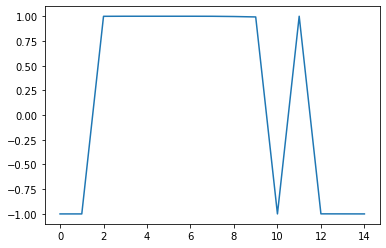

In [443]:
plt.plot(np.array(generator(np.matrix(np.transpose(input_data)[0])))[0])


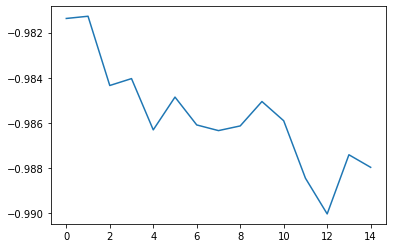

In [439]:
plt.plot(np.array(np.transpose(output_data)[0]))